AlignedUMAP for Time Varying Data
==============================

It is not uncommon to have datasets that can be partitioned into segments, often with respect to time, where we want to understand not only the structure of each segment, but how that structure changes over the different segments. An example of this is the relative political leanings of the US congress over time. In determining the relative political leanings we can look at the representatives voting record on roll call votes, with the presumption that representatives with similar political principles will have similar voting records. We can, of course, look at such data for any given congress, but since representatives are commonly re-elected we can also consider how their relative position in congress changes with time -- an ideal use case for AlignedUMAP.

First we'll need a selection of libraries. Aside from UMAP we will need to do a little bit of data wrangling; for that we'll need pandas, and also for matching up names of representatives we'll make use of the library ``fuzzywuzzy`` which provides easy to use fuzzy string matching.

In [1]:
import umap
import umap.utils as utils
import umap.aligned_umap
import sklearn.decomposition

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import fuzz, process
import re

/home/leland/anaconda3/envs/umapper/lib/python3.8/site-packages/umap/__init__.py:8: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
sns.set(style="darkgrid", color_codes=True)

Next we'll need to voting records for the representatives, along with the associated metadata from the roll call vote records. You can obtain the data https://clerk.house.gov; a notebook demonstrating how to pull down the data and parse it into the csv files used here is available [here](https://github.com/lmcinnes/umap_doc_notebooks/blob/master/parse_voting_records.ipynb).

Processing Congressional Voting Records
------------------------------------------------------------

The voting records provide a row for each representative with a -1 for "No", 0 for "Present" or "Not Voting", and 1 for "Aye". A separate csv file contains the raw data of all the votes with a row for each legislators vote on each roll-call item. We really just need some metadata -- which state they represent and the party they represent so we can decorate the results with this kind of information later. For that we just need to extra the names, states, and parties for each year. We can grab those columns and then drop duplicates. A catch: the party is very occasionally entered incorrectly, and occasionally representatives switch parties, making duplicated rows. We'll just take the first entry of such duplciates for now.

In [3]:
votes = [pd.read_csv(f"house_votes/{year}_voting_record.csv", index_col=0).sort_index()
         for year in range(1990,2021)]
metadata = [pd.read_csv(
    f"house_votes/{year}_full.csv", 
    index_col=0
)[["legislator", "state", "party"]].drop_duplicates(["legislator", "state"]).sort_values('legislator') 
            for year in range(1990,2021)]

Let's take a look at the voting record for a single year to see what sort of data we are looking at:

In [4]:
votes[5]

,104-1st-1,104-1st-10,104-1st-100,104-1st-101,104-1st-102,104-1st-103,104-1st-104,104-1st-105,104-1st-106,104-1st-107,...,104-1st-90,104-1st-91,104-1st-92,104-1st-93,104-1st-94,104-1st-95,104-1st-96,104-1st-97,104-1st-98,104-1st-99
legislator,,,,,,,,,,,,,,,,,,,,,
Abercrombie,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
Ackerman,0.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
Allard,0.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,0.0,-1.0
Andrews,0.0,1.0,0.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,...,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0
Archer,0.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young (AK),0.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0
Young (FL),0.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0
Zeliff,0.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0


We can examine the associated metadata for the same year.

In [5]:
metadata[5]

,legislator,state,party
0,Abercrombie,HI,D
1,Ackerman,NY,D
2,Allard,CO,R
3,Andrews,NJ,D
4,Archer,TX,R
...,...,...,...
430,Young (AK),AK,R
431,Young (FL),FL,R
432,Zeliff,NH,R
433,Zimmer,NJ,R


You may note that sometimes representatives names list a state in parenthesis afterwards. This is to provide disambiguation for representatives that happen to have the last name. This actually complicates matters for us since the disambiguation is only applied in those cases where there is a name collision in that sitting of congress. That means that for several years a representative may have simply their last name, but then switch to being disambiguated, before potentially switching back again. This would make it much harder to consistently treck representatives over their entire career in congress. To fix this up we'll simply re-index by a unique representative ID that has their last name, party, and state all listed over all the voting dataframes. We'll need a function to generate those from the metadata, and then we'll need to apply it to all the reocrds. Importantly we'll have to finesse those situations where representatives are listed twice (under un-ambiguous and disambiguated names) with some groupby tricks.

In [6]:
def unique_legislator(row):
    name, state, party = row.legislator, row.state, row.party
    # Strip of disambiguating state designators
    if re.search(r'(\w+) \([A-Z]{2}\)', name) is not None:
        name = name[:-5]
    return f"{name} ({party}, {state})"

In [7]:
for i, _ in enumerate(votes):
    votes[i].index = pd.Index(metadata[i].apply(unique_legislator, axis=1), name="legislator_index")
    votes[i] = votes[i].groupby(level=0).sum()
    metadata[i].index = pd.Index(metadata[i].apply(unique_legislator, axis=1), name="legislator_index")
    metadata[i] = metadata[i].groupby(level=0).first()

Now that we have the data at least a little wrangled into order there is the question of ensuring some degree of continuity fore representatives. To make this a little easier we'll use voting records over *four year spans* instead of over single years. Equally importantly we'll do this in a sliding window fashion so that we consider the record for 1990-1994 and then the record for 1991-1995 and so on. By overlapping the windows in this way we can ensure a little greater continuity of political stance through the years. To make this happen we just have to merge data frames in a sliding set of pairs, and then merge the pairs via the same approach: 

In [8]:
votes = [
    pd.merge(
        v1, v2, how="outer", on="legislator_index"
    ).fillna(0.0).sort_index()
    for v1, v2 in zip(votes[:-1], votes[1:])
] + votes[-1:]

metadata = [
    pd.concat([m1, m2]).groupby("legislator_index").first().sort_index()
    for m1, m2 in zip(metadata[:-1], metadata[1:])
] + metadata[-1:]

That's the pairs of years; now we merge these pairwise to get sets of four years worth of votes.

In [9]:
votes = [
    pd.merge(
        v1, v2, how="outer", on="legislator_index"
    ).fillna(0.0).sort_index()
    for v1, v2 in zip(votes[:-1], votes[1:])
] + votes[-1:]

metadata = [
    pd.concat([m1, m2]).groupby(level=0).first().sort_index()
    for m1, m2 in zip(metadata[:-1], metadata[1:])
] + metadata[-1:]

Applying AlignedUMAP
---------------------------------

To make use of AlignedUMAP we need to generate relations between consecutive dataset slices. In this case that means we need to have a relation describing row from one four year slice corresponds to a row from the following four year slice for the same representative. For AlignedUMAP to work this should be formatted as a list of dictionaries; each dictionary gives a mapping from indices of one slice to indices of the next. Importantly this mapping can be partial -- it only has to relate indices for which there is a match between the two slices.

The vote dataframes that we are using for slices are already indexed with unique identifiers for representatives, so to make relations we simply have to match them up, creating a dictionary of indices from one to the other. In practice we can do this relatively efficiently by using pandas to merge dataframes on the pandas indexes of the two vote dataframes with the data being simply the numeric indices of the rows. The resulting dictionary is then just the dictionary of pairs given by the inner join.

In [10]:
def make_relation(from_df, to_df):
    left = pd.DataFrame(data=np.arange(len(from_df)), index=from_df.index)
    right = pd.DataFrame(data=np.arange(len(to_df)), index=to_df.index)
    merge = pd.merge(left, right, left_index=True, right_index=True)
    return dict(merge.values)

With a function for relation creation in place we simply need to apply it to each consecutive pair of vote dataframes.

In [11]:
relations = [make_relation(x,y) for x, y in zip(votes[:-1], votes[1:])]

If you are still unsure of what these relations are it might be beneficial to look at a few of the dictionaries, along with the corresponding pairs of vote dataframes. Here is (part of) the first relation dictionary:

In [12]:
relations[0]

{0: 0,
 1: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 21,
 20: 22,
 21: 26,
 22: 28,
 23: 30,
 24: 31,
 25: 32,
 27: 34,
 28: 35,
 29: 36,
 30: 37,
 31: 38,
 32: 39,
 33: 40,
 34: 41,
 35: 43,
 36: 44,
 37: 46,
 38: 47,
 40: 49,
 41: 50,
 43: 51,
 44: 52,
 46: 53,
 47: 54,
 48: 55,
 49: 56,
 50: 57,
 52: 60,
 53: 61,
 55: 62,
 56: 63,
 57: 64,
 58: 67,
 59: 68,
 60: 70,
 61: 71,
 62: 72,
 63: 75,
 64: 76,
 65: 77,
 66: 79,
 67: 80,
 69: 81,
 70: 83,
 71: 84,
 72: 86,
 73: 87,
 74: 88,
 75: 89,
 76: 90,
 77: 92,
 78: 93,
 79: 94,
 80: 95,
 81: 96,
 82: 98,
 83: 99,
 85: 100,
 86: 101,
 87: 102,
 89: 103,
 90: 104,
 92: 106,
 93: 107,
 94: 109,
 95: 110,
 96: 111,
 97: 112,
 98: 113,
 100: 115,
 101: 116,
 102: 120,
 103: 121,
 104: 122,
 105: 123,
 106: 124,
 107: 125,
 108: 126,
 109: 127,
 110: 128,
 112: 129,
 113: 130,
 114: 131,
 115: 133,
 116: 134,
 117: 135,
 119: 136,
 120: 137,
 121: 

Now we are finally in  a position to run AlignedUMAP. Most of the standard UMAP parameters are available for use, including choosing a metric and a number of neighbors. Here we will also make use of the extra AlignedUMAP parameters ``alignment_regularisation`` and ``alignment_window_size``. The first is a value that weights how important retaining alignment is. Typically the value is much smaller than this (the default is 0.01), but given the relatively high volatility in voting records we are going to increase it here. The second parameter, ``alignment_window_size`` determines how far out on either side AlignedUMAP will look when aligning embeddings -- even though the relations are specified only between consecutive slices it will chain them together to construct relations reaching further. In this case we'll have it look as far out as 5 slices either side.

In [13]:
%%time
aligned_mapper = umap.aligned_umap.AlignedUMAP(
    metric="cosine",
    n_neighbors=20,
    alignment_regularisation=0.1, 
    alignment_window_size=5,
    n_epochs=200,
    random_state=42,
).fit(votes, relations=relations)
embeddings = aligned_mapper.embeddings_

/home/leland/anaconda3/envs/umapper/lib/python3.8/site-packages/umap/umap_.py:874: RuntimeWarning: overflow encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]


CPU times: user 6min 7s, sys: 30.6 s, total: 6min 37s
Wall time: 5min 57s


Visualizing the Results
---------------------------------

Now we need to plot the data somehow. To make the visualization interesting it would be beneficial to have some colour variation -- ideally showing a different view of the relative political stance. For that we want to attempt to get an idea of the position of each candidate from an alternative source. To do this we can try to extract the vote margin that the representative won by. The catch here is that while the election data can be collected and processed, the names don't match perfectly as they come from a different source. That means we need to do our best to get a name match for each candidate. We'll use fuzzy string matching restricted to the relevant year and state to try to get a good match. A notebook providing details for obtaining and processing the election winners data can be found [here](https://github.com/lmcinnes/umap_doc_notebooks/blob/master/voting_data_by_district.ipynb).

In [14]:
election_winners = pd.read_csv('election_winners_1976-2018.csv', index_col=0)
election_winners.head()

,year,state,district,winner,party,winning_ratio
0,1976,AK,0,Don Young,republican,0.289986
0,1976,AL,1,Jack Edwards,republican,0.374808
0,1976,AL,2,"William L. \\""Bill\""\"" Dickinson""",republican,0.423953
0,1976,AL,3,Bill Nichols,democrat,1.000000
0,1976,AL,4,Tom Bevill,democrat,0.803825


Now we need to simply go through the metadata and fill it out with the extra information we can glean from the election winners data. Since we can't do exact name matching (the data for both is somewhat messy when it comes to text fields like names) we can't simply perform a join, but must instead process things year by year and representative by representative, finding the best string match on name that we can for the given year and state election. In practice we are undoubtedly going to get some of these wrong, and if the goal was a rigorous analysis based on this data a lot more care would need to be taken. Since this is just a demonstration and we'll only be using this extra information as a colour channel in plots we can excuise a few errors here and there from in-exact data processing.

In [15]:
n_name_misses = 0
for year, df in enumerate(metadata, 1990):
    df["partisan_lean"] = 0.5
    df["district"] = np.full(len(df), -1, dtype=np.int8)
    for idx, (loc, row) in enumerate(df.iterrows()):
        name, state, party = row.legislator, row.state, row.party
        # Strip of disambiguating state designators
        if re.search(r'(\w+) \([A-Z]{2}\)', name) is not None:
            name = name[:-5]
        # Get a party designator matching the election_winners data
        party = "republican" if party == "R" else "democrat"
        # Restrict to the right state and time-frame
        state_election_winners = election_winners[(election_winners.state == state) 
                                                  & (election_winners.year <= year + 4)
                                                  & (election_winners.year >= year - 4)]
        # Try to match a name; and fail "gracefully"
        try:
            matched_name = process.extractOne(
                name, 
                state_election_winners.winner.tolist(),
                scorer=fuzz.partial_token_sort_ratio,
                score_cutoff=50,
            )
        except:
            matched_name = None
            
        # If we got a unique match, get the election data
        if matched_name is not None:
            winner = state_election_winners[state_election_winners.winner == matched_name[0]]
        else:
            winner = []
            
        # We either have none, one, or *several* match elections. Take a best guess.
        if len(winner) < 1:
            df.loc[loc, ["partisan_lean"]] = 0.25 if party == "republican" else 0.75
            n_name_misses += 1
        elif len(winner) > 1:
            df.iloc[idx, 4] = int(winner.district.values[-1])
            df.iloc[idx, 3] = float(winner.winning_ratio.values[-1])
        else:
            df.iloc[idx, 4] = int(winner.district.values)
            df.iloc[idx, 3] = float(winner.winning_ratio.values[0])
            
print(f"Failed to match a name {n_name_misses} times")

Failed to match a name 100 times


Now that we have the relative partisan leanings based on district election margins we can color the plot. We can obviously label the plot with the representatives names. The last remaining catch (when using matplotlib for the plotting) is the get the plot bounds (since we will be placing text markers directly into the plot, and thus not autogenerating bounds). This is a simple enough matter of computing some bounds as an adjustment a little outside the data limits.

In [16]:
def axis_bounds(embedding):
    left = embedding.T[0].min()
    right = embedding.T[0].max()
    bottom = embedding.T[1].min()
    top = embedding.T[1].max()
    width = right - left
    height = top - bottom
    adj_h = width * 0.1
    adj_v = height * 0.05
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

Now for the plot. Let's pick a random time slice (you are welcome to try others) and draw the representatives names in their embedded locations for that slice, coloured by their relative election victory margin.

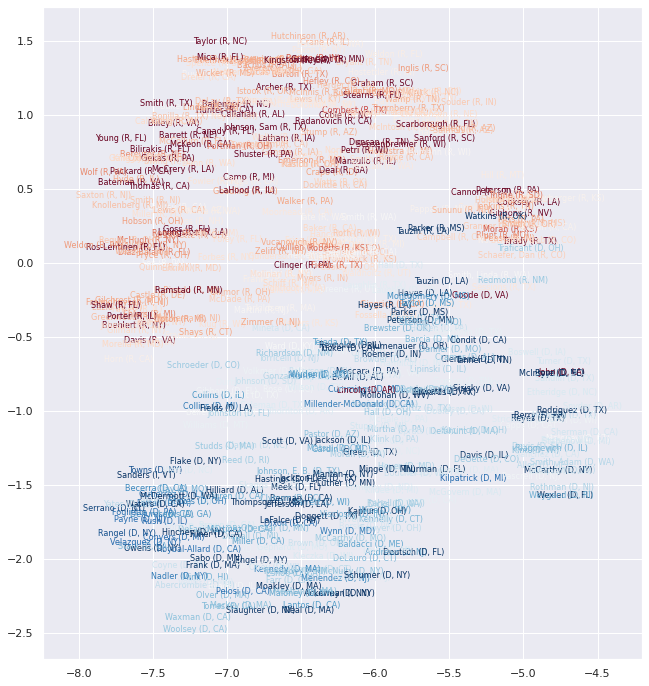

In [17]:
fig, ax = plt.subplots(figsize=(12,12))
e = 5
ax.axis(axis_bounds(embeddings[e]))
ax.set_aspect('equal')
for i in range(embeddings[e].shape[0]):
    ax.text(embeddings[e][i, 0],
            embeddings[e][i, 1],
            metadata[e].index.values[i],
            color=plt.cm.RdBu(np.float32(metadata[e]["partisan_lean"].values[i])), 
            fontsize=8,
            horizontalalignment='center',
            verticalalignment='center',
           )


This gives a good idea of the layout in a single time slices, and by plotting different time slices we can get some idea of how things have evolved. We can go further, however, by plotting a representative as curve through time as their relative political position in congress changes. For that we will need a 3D plot -- we need both the UMAP x and y coordinates, as well as a third coordinate giving the year. I found this easiest to do in plotly, so let's import that. To make nice smooth curves through time we will also import the ``scipy.interpolate`` module which will let is interpolate a smooth curve from the discrete positions that a representatives appears in over time.

In [18]:
import plotly.graph_objects as go
import scipy.interpolate

Wrangling the data into shape for this is the next step; first let's get everything in a single dataframe that we can extract relevant data from on an as-needed basis.

In [19]:
df = pd.DataFrame(np.vstack(embeddings), columns=('x', 'y'))
df['z'] = np.concatenate([[year] * len(embeddings[i]) for i, year in enumerate(range(1990, 2021))])
df['representative_id'] = np.concatenate([v.index for v in votes])
df['partisan_lean'] = np.concatenate([m["partisan_lean"].values for m in metadata])

Next we'll need that interpolation of the curve for a given representative. We'll write a function to handle that as there is a little bit of case-based logic that makes it non-trivial. We are going to get handed year data and want to interpolate the UMAP x and y coordinates for a single representative. 

The first major catch is that many representatives don't have a single contiguous block of years for which they were in congress: they were elected for several years, missed re-election, and then came back to congress several years later (possibly in another district). Each such block of contiguous years needs to be a separate path, and we shouldn't connect them. We therefore need some logic to find the contiguous blocks and generate smooth paths for each of them.

Another catch is that Ssome representatives have only been in office for a year or two (special elections and so forth) and we can't do a cubic spline interpolation for that; we can devolve to linear interpolation or quadratic splines for those cases, so simply add the point itself for the odd single year cases.

With those issues in hand we can then simply use the scipy ``interp1d`` function to generate smooth curves through the points.

In [20]:
INTERP_KIND = {2:"linear", 3:"quadratic", 4:"cubic"}

def interpolate_paths(z, x, y, c, rep_id):
    consecutive_year_blocks = np.where(np.diff(z) != 1)[0] + 1
    z_blocks = np.split(z, consecutive_year_blocks)    
    x_blocks = np.split(x, consecutive_year_blocks)
    y_blocks = np.split(y, consecutive_year_blocks)  
    c_blocks = np.split(c, consecutive_year_blocks)
    
    paths = []
    
    for block_idx, zs in enumerate(z_blocks):
        
        text = f"{rep_id} -- partisan_lean: {np.mean(c_blocks[block_idx]):.2f}"
        
        if len(zs) > 1:
            kind = INTERP_KIND.get(len(zs), "cubic")
        else:
            paths.append(
                (zs, x_blocks[block_idx], y_blocks[block_idx], c_blocks[block_idx], text)
            )
            continue
            
        z = np.linspace(np.min(zs), np.max(zs), 100)
        x = scipy.interpolate.interp1d(zs, x_blocks[block_idx], kind=kind)(z)
        y = scipy.interpolate.interp1d(zs, y_blocks[block_idx], kind=kind)(z)
        c = scipy.interpolate.interp1d(zs, c_blocks[block_idx], kind="linear")(z)
        
        paths.append((z, x, y, c, text))
        
    return paths

And now we can use plotly to draw the resulting curves. For plotly we use the ``Scatter3D`` method, which supports a "lines" mode that can draw curves in 3D space. We can colour the curves by the partisan lean score we derived from the election data -- in fact the colour can vary through the trace as the election margins vary. Since this is a plotly plot it is interactive, so you can rotate it around and view it from all angles.

In [22]:
traces = []
for rep in df.representative_id.unique():
    z = df.z[df.representative_id == rep].values
    x = df.x[df.representative_id == rep].values
    y = df.y[df.representative_id == rep].values
    c = df.partisan_lean[df.representative_id == rep]
    
    for z, x, y, c, text in interpolate_paths(z, x, y, c, rep):
        trace = go.Scatter3d(
            x=x, y=z, z=y, 
            mode="lines",
            hovertext=text,
            hoverinfo="text",
            line=dict(
                color=c,
                cmin=0.0,
                cmid=0.5,
                cmax=1.0,
                cauto=False,
                colorscale="RdBu",
                colorbar=dict(),
                width=2.5,
            ),
            opacity=1.0,
        )
        traces.append(trace)

fig = go.Figure(data=traces)
fig.update_layout(
    width=800,
    height=600,
    scene=dict(
        aspectratio = dict( x=0.5, y=1.25, z=0.5 ),
        yaxis_title="Year",
        xaxis_title="UMAP-X",
        zaxis_title="UMAP-Y",
    ),
    scene_camera=dict(eye=dict( x=0.5, y=0.8, z=0.75 )),
    autosize=False,
    showlegend=False,
)
fig.write_html('umapper_politics_spaghetti-plot.html', include_plotlyjs="cdn")
fig.write_image('umapper_politics_spaghetti-plot.png')
fig_widget = go.FigureWidget(fig)
fig_widget

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'hovertext': 'Abercrombie (D, HI) -- partisan_…